In [1]:
simulation_num <- 1

set.seed(1)


maxsteps = 100
my.minlam <- 10^(-5)
nfold <- 10
outerCV_folds <- 5
graphComponents <- 2
percent <- 0.8

feature.names <- c("A", "B")

intercept_mode <- TRUE

outPath <- "~/mount2/flassoTool/simulation/sim/"

source('~/mount2/flassoTool/wrapper_functions_RSSmeasureModelSelection_gamma_parallel.R')
source('~/mount2/flassoTool/UtilityFunctions_sequentialCV.R')


In [2]:
feature.names <- c("A", "B")
fileName <- paste("simulation",simulation_num, sep="")

In [3]:
data.x <- as.matrix(read.table(paste("~/mount2/flassoTool/simulation/fl_sim_features_",simulation_num,".txt", sep="")))
data.y <- as.numeric(readLines(paste("~/mount2/flassoTool/simulation/fl_sim_response_",simulation_num,".txt", sep="")))

Y = rowSums(data.x[, seq(21, 30), seq(31, 40)]) * 3 + 4
Y[seq(301, 600)] = -rowSums(data.x[seq(301, 600), ])

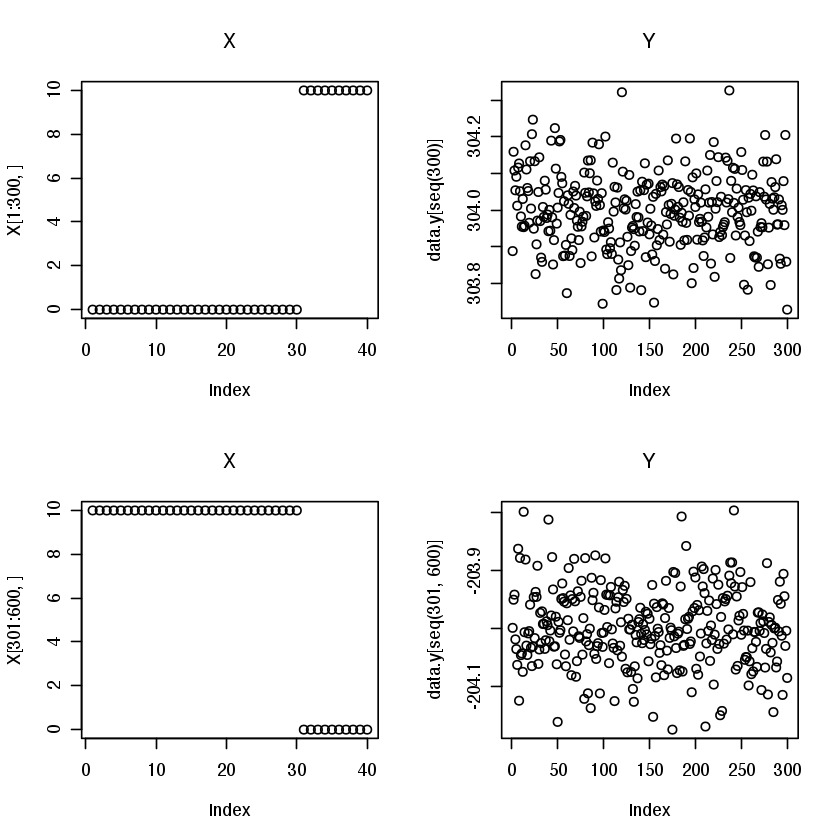

In [4]:
cat("Y = rowSums(data.x[, seq(21, 30), seq(31, 40)]) * 3 + 4
Y[seq(301, 600)] = -rowSums(data.x[seq(301, 600), ])")

par(mfrow= c(2,2));
plot(colMeans(data.x[seq(300),]), main= "X", ylab= "X[1:300, ]")
plot(data.y[seq(300)], main= "Y")
plot(colMeans(data.x[seq(301, 600),]), main= "X", ylab= "X[301:600, ]")
plot(data.y[seq(301, 600)], main= "Y")


In [5]:
bestGammasIdx <- 1
ctr <- 1

shuffle <- sample(length(data.y))
data.x <- data.x[shuffle,]
data.y <- data.y[shuffle]

In [6]:
bin.cnt <- ncol(data.x)/graphComponents
edgs <- NULL
for(i in 1:graphComponents)
{
    edgs <- c(edgs,bin.cnt*(i-1)+1, rep((bin.cnt*(i-1)+2):(bin.cnt*i - 1),each=2),bin.cnt*i)
}

In [7]:
partition <- data.partition(data.x,data.y,percent=percent)

In [8]:
train.group.rescaled <- group.rescale(partition$train$x,0,1,bin.cnt)
partition$train$x <- train.group.rescaled$x
partition$test$x <- group.rescale(partition$test$x,0,1,bin.cnt,train.group.rescaled$min,train.group.rescaled$max)$x

In [9]:
outer_CV_partitions <- get.outerCV.partitions(data.x,data.y,n.folds=outerCV_folds)

In [10]:
gammas <- 0
for(i in seq(-5,5)){
    gammas <- c(gammas,(10^i))
}

In [11]:
bestgammas <-vector(mode='numeric',length=1)
bestGammasIdx <- 1

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-10



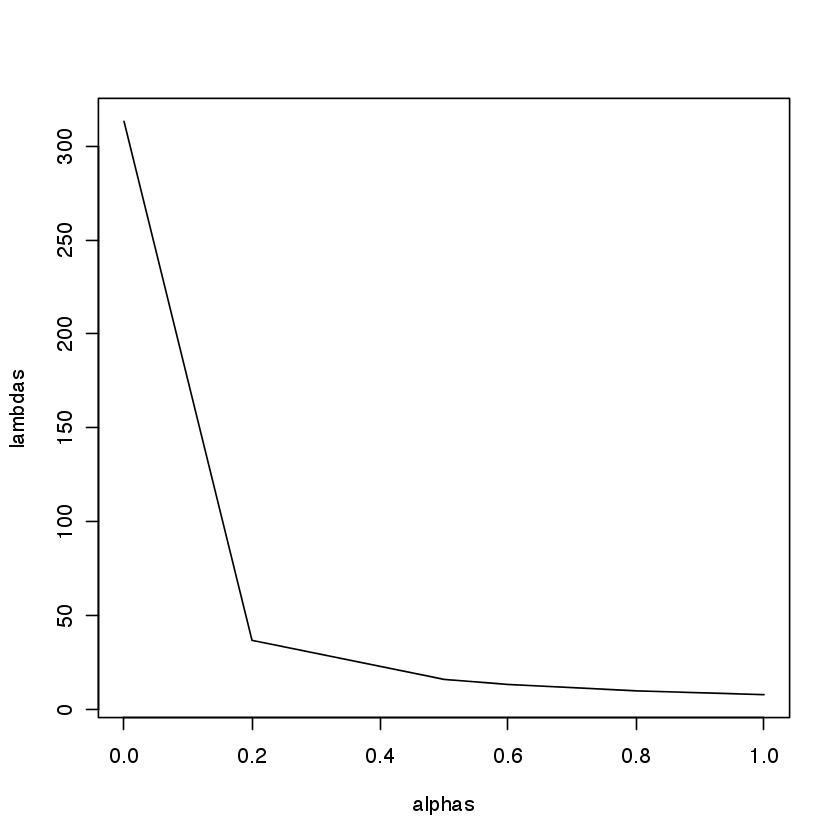

In [12]:
library(glmnet)
alphas <- c(0, .2, .5, .6, .8, 1)
cv.elastic <- list()
el <- list()
pred <- list()

for(i in seq(length(alphas))){
  cv.elastic[[i]] <- cv.glmnet(x= as.matrix(partition$train$x), y= as.numeric(partition$train$y), alpha= alphas[i])
  el[[i]] <- glmnet(x= as.matrix(partition$train$x), y= as.numeric(partition$train$y), alpha= alphas[i], lambda= cv.elastic[[i]]$lambda.min)
  pred[[i]] <- predict(el[[i]], newx= as.matrix(partition$test$x))
}

plot(x= alphas, y= c(cv.elastic[[1]]$lambda.min, cv.elastic[[2]]$lambda.min, cv.elastic[[3]]$lambda.min, cv.elastic[[4]]$lambda.min, cv.elastic[[5]]$lambda.min, cv.elastic[[6]]$lambda.min), xlab= "alphas", ylab= "lambdas", type= "l")


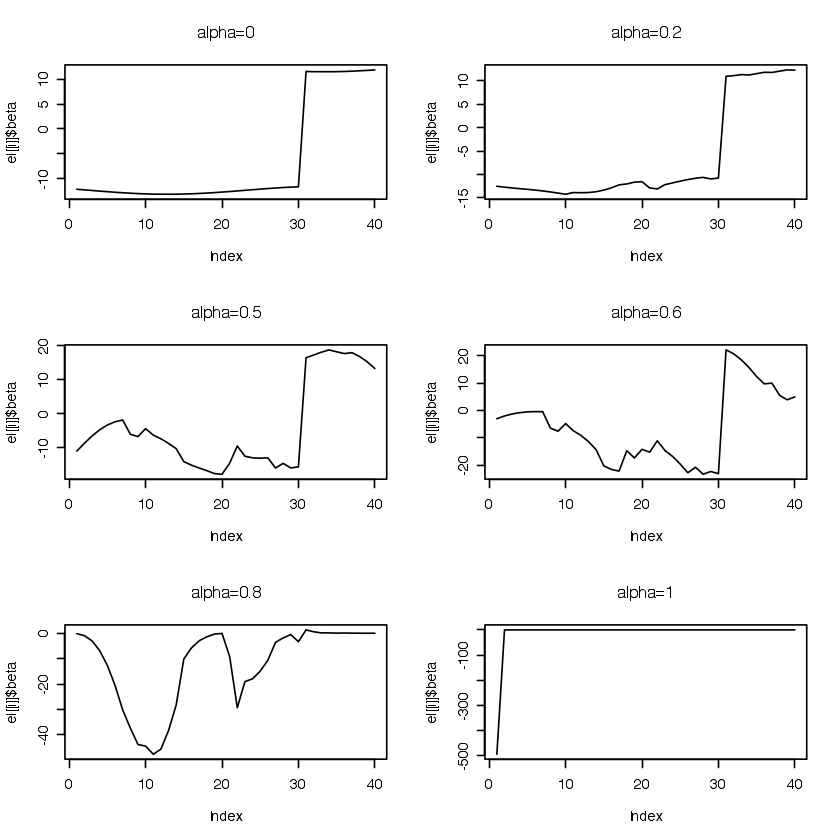

In [13]:
par(mfrow= c(3,2))
for(i in seq(length(alphas)))
  plot(el[[i]]$beta, type= "l", main= paste("alpha=", alphas[i],sep= ""));

[1] "pearson"
[1] "alpha= 0 --> cor= 1"   "alpha= 0.2 --> cor= 1" "alpha= 0.5 --> cor= 1"
[4] "alpha= 0.6 --> cor= 1" "alpha= 0.8 --> cor= 1" "alpha= 1 --> cor= 1"  
[1] "spearman"
[1] "alpha= 0 --> cor= 0.947"   "alpha= 0.2 --> cor= 0.943"
[3] "alpha= 0.5 --> cor= 0.969" "alpha= 0.6 --> cor= 0.962"
[5] "alpha= 0.8 --> cor= 0.845" "alpha= 1 --> cor= 0.8"    


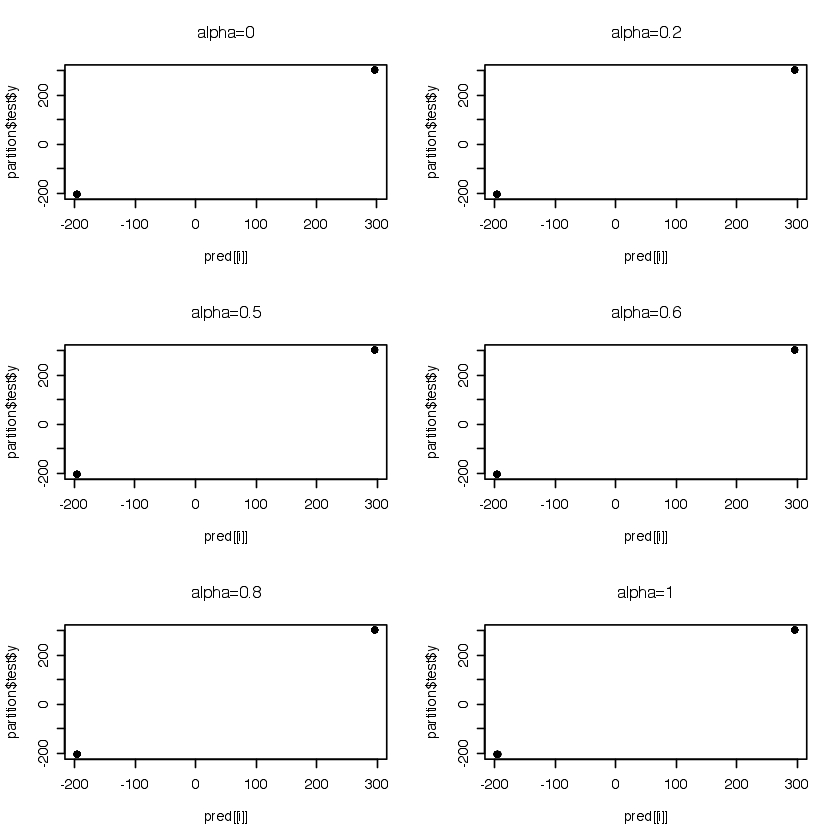

In [14]:
par(mfrow= c(3,2));
for(i in seq(length(alphas)))
  plot(pred[[i]], partition$test$y, pch= 20, main= paste("alpha=", alphas[i],sep= ""));

cors_pearson <- NULL
cors_spearman <- NULL


for(i in seq(length(alphas))){
    cors_pearson <- c(cors_pearson, round(cor(pred[[i]], partition$test$y, method= "pearson"), 3))
    cors_spearman <- c(cors_spearman, round(cor(pred[[i]], partition$test$y, method= "spearman"), 3))
}
print("pearson")
print(paste("alpha=", alphas, "--> cor=", cors_pearson, sep= " "))
print("spearman")
print(paste("alpha=", alphas, "--> cor=", cors_spearman, sep= " "))

In [15]:
fl.outerCV <- sapply(seq(outerCV_folds),function(i)fusedlasso.main_ForLambdaInterpolation(outer_CV_partitions[[i]]$train$x,outer_CV_partitions[[i]]$train$y,bin.cnt,edgs,gammas,intercept_mode))

Loading required package: doSNOW
Loading required package: iterators
Loading required package: snow
Loading required package: scatterplot3d
Loading required package: parallel

Attaching package: ‘parallel’

The following objects are masked from ‘package:snow’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, clusterSplit, makeCluster, parApply,
    parCapply, parLapply, parRapply, parSapply, splitIndices,
    stopCluster

Loading required package: genlasso
Loading required package: MASS
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



[1] 120
[1] 30
[1] 12
[1] "0 8.00210497384747e-07"
[1] "1e-05 0.0104270947503883"
[1] "1e-04 0.0101851462685418"
[1] "0.001 0.00747291208425944"
[1] "0.01 0.00704122542284399"
[1] "0.1 0.00704122288846883"
[1] "1 0.00704121301491711"
[1] "10 0.00704184878006163"
[1] "100 0.00707452892122333"
[1] "1000 0.00722338098522663"
[1] "10000 0.0072979358054234"
[1] "1e+05 0.00730817424313486"
[1] "search.depth=1"
 [1] "gammas="    "0"          "0"          "0"          "0"         
 [6] "0"          "0"          "0"          "0"          "0"         
[11] "0"          "best.gamma" "0"         
[1] "single gamma set"
[1] 120
[1] 30
[1] 12
[1] "0 8.41070227578901e-07"
[1] "1e-05 0.010270144607669"
[1] "1e-04 0.00962166685459168"
[1] "0.001 0.00749304805870289"
[1] "0.01 0.00689671906410473"
[1] "0.1 0.00689671523986174"
[1] "1 0.00689668641970265"
[1] "10 0.00689733106147288"
[1] "100 0.00692258619072695"
[1] "1000 0.00711397223827855"
[1] "10000 0.00719349587721184"
[1] "1e+05 0.0071964180782224

In [16]:
  fl <- fusedlasso.main_ForLambdaInterpolation(partition$train$x,partition$train$y,bin.cnt,edgs,gammas,intercept_mode)

[1] 120
[1] 30
[1] 12
[1] "0 8.00764565828981e-07"
[1] "1e-05 1.75638483992578e-06"
[1] "1e-04 1.75638485578306e-06"
[1] "0.001 9.59061336483662e-07"
[1] "0.01 8.00689751222244e-07"
[1] "0.1 8.00066378348334e-07"
[1] "1 8.08597955029067e-07"
[1] "10 1.42462759459833e-06"
[1] "100 1.50658145868548e-05"
[1] "1000 0.00448661681020317"
[1] "10000 0.00482299060484413"
[1] "1e+05 0.00483471497100257"
[1] "search.depth=1"


In [17]:
best.cv.gamma <- fl$gamma.best

In [18]:
if(intercept_mode){
    edgs <- edgs + 1
    edgs <- c(1,1,edgs)
}

if(intercept_mode){
    fl.best <- fusedlasso(X=cbind(1,partition$train$x),y=partition$train$y,graph=graph(edgs,directed=F),gamma=best.cv.gamma,maxsteps = maxsteps,minlam=my.minlam)
  }else{
    fl.best <- fusedlasso(X=partition$train$x,y=partition$train$y,graph=graph(edgs,directed=F),gamma=best.cv.gamma,maxsteps = maxsteps,minlam=my.minlam)
}


In [19]:
bestgammas[bestGammasIdx] <- fl$gamma.best

In [20]:
fl.best.min.lambda <- min(fl.best$lambda) 
  beta.best <- coef.genlasso(fl.best,max(fl.best.min.lambda,fl$best.lambda))$beta
  print('Done running fusedlasso.main')
  cv.beta.mat.fl <- fl$cv.fl$cv.beta.mat
  print(c('dim(cv.beta.mat.fl)',dim(cv.beta.mat.fl)))
  cv.beta.mat.nl <- cv.beta.matrix.nl(partition$train$x,partition$train$y,nfold)

[1] "Done running fusedlasso.main"
[1] "dim(cv.beta.mat.fl)" "10"                  "41"                 
[1] "length(nl.beta)" "41"             


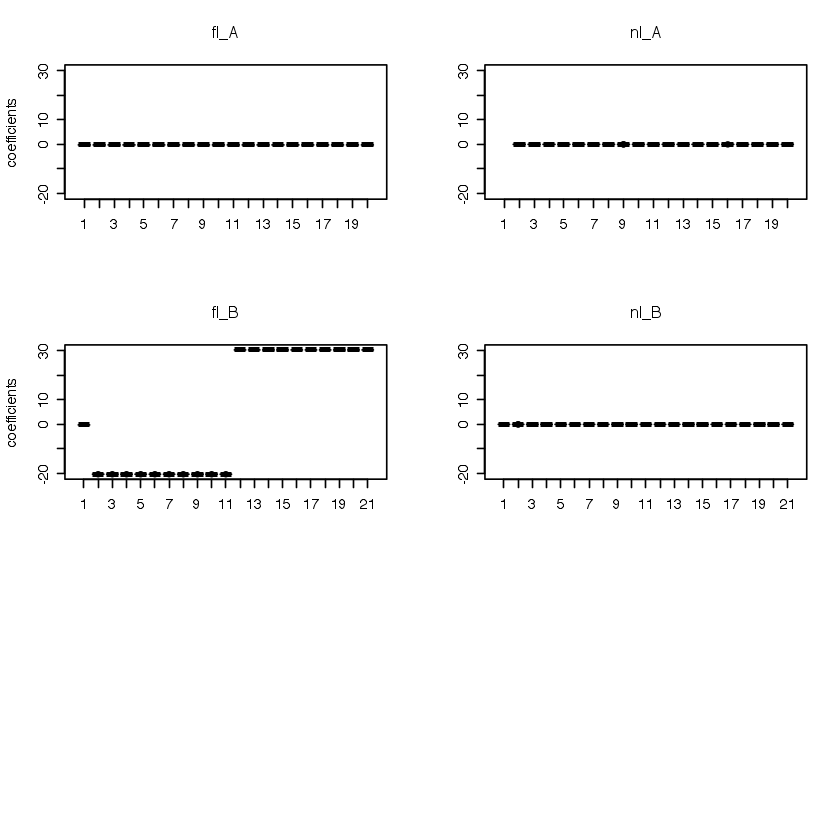

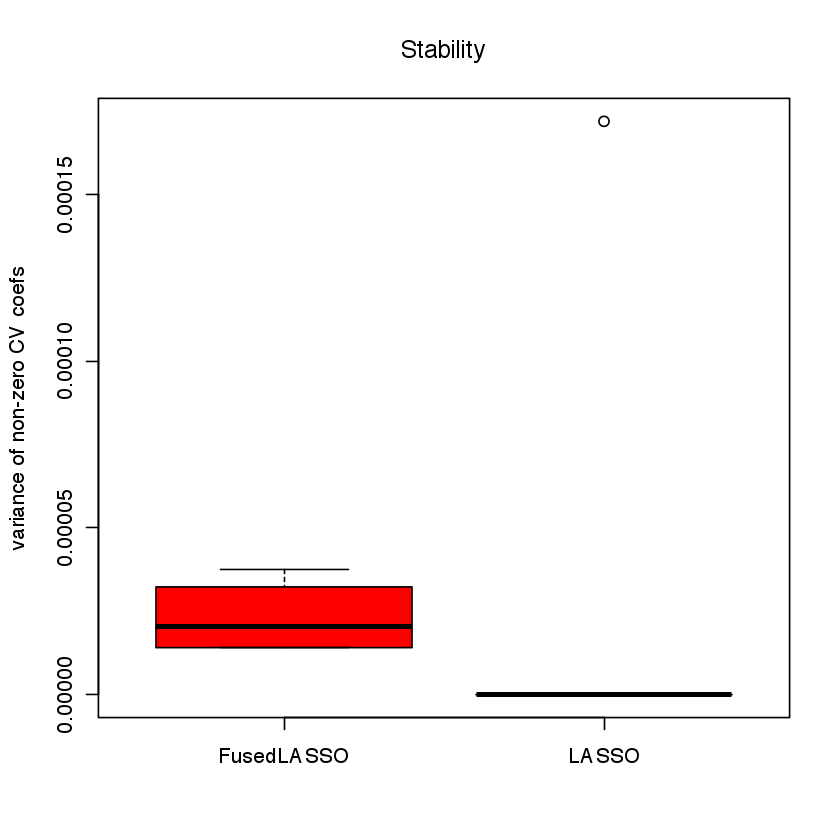

In [21]:
plot.stability(cv.beta.mat.fl,cv.beta.mat.nl$cv.beta,bin.cnt,feature.names,intercept_mode)
  plot.stability.var(cv.beta.mat.fl,cv.beta.mat.nl$cv.beta,intercept_mode)

Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



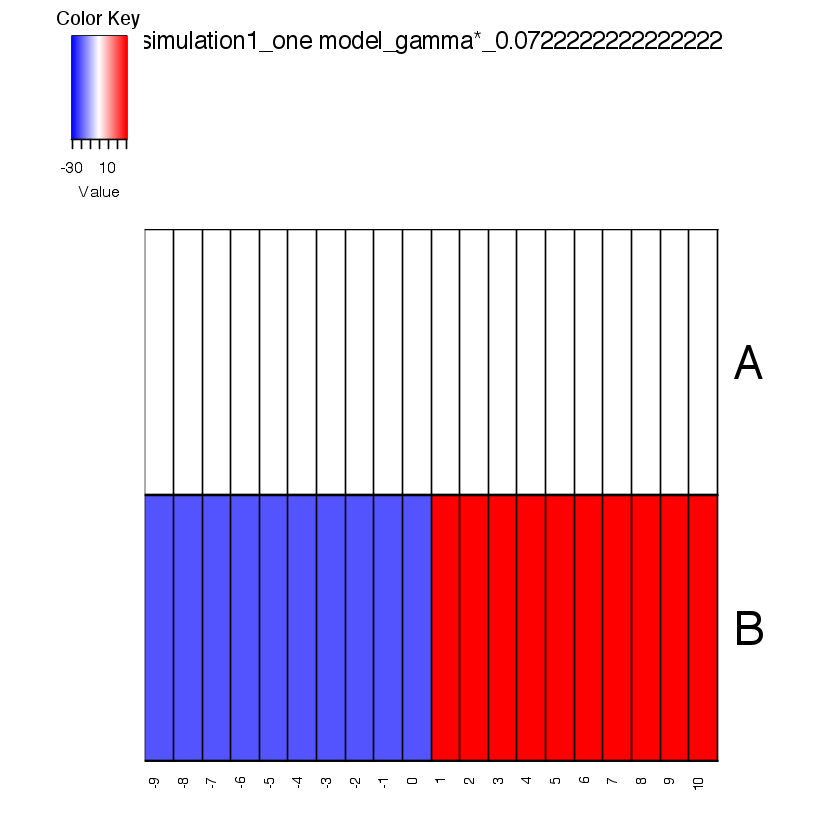

In [22]:
plot.histone.coef(beta.best,bin.cnt,feature.names,main=paste(fileName,'one model','gamma*',bestgammas[bestGammasIdx],sep='_'),intercept_mode)#,cluster_rows = F, cluster_cols = F)

In [23]:
correlations.fl <- matrix(0,ncol=3,nrow=2)#2 rows for spearman and pearson correlation and 3 columns for test, train, and entire dataset
  correlations.nl <- matrix(0,ncol=3,nrow=2)

In [24]:
test.y <- partition$test$y
  if(intercept_mode){
    test.x <- partition$test$x
    train.x <- partition$train$x
    entire.x <- rbind(partition$train$x,partition$test$x)
  }else{
    test.x <- partition$test$x
    train.x <- partition$train$x
    entire.x <- rbind(train.x,test.x)
  }

$rss
[1] 0.0009426573

$cor
[1] 1 1

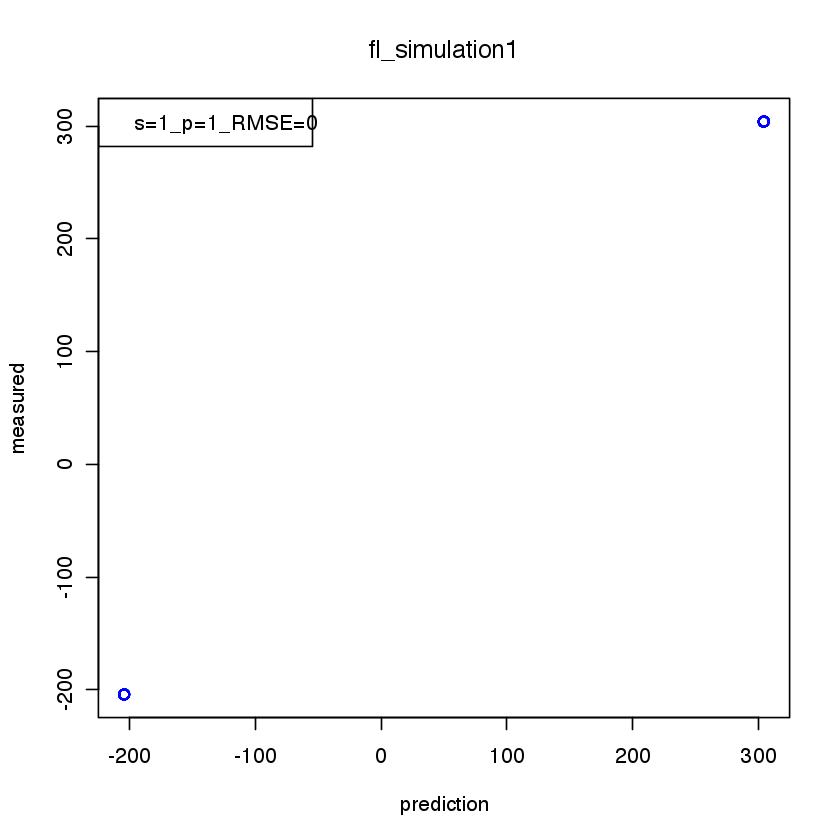

In [25]:
plot.scatter(test.x,test.y,beta.best,0,"measured",main=paste('fl',fileName,sep='_'),is_fl=T,intercept_mode,xlab='prediction')

$rss
[1] 8.163777

$cor
[1] 0.8 1.0

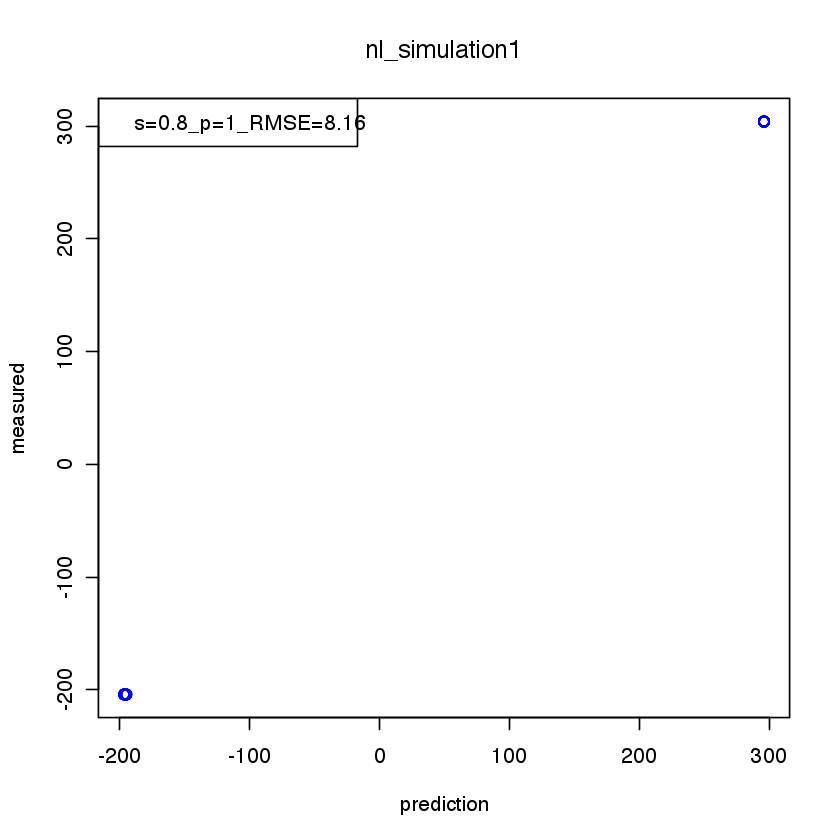

In [26]:
plot.scatter(partition$test$x,partition$test$y,cv.beta.mat.nl$best.nl,0,"measured",main=paste('nl',fileName,sep='_'),is_fl=F,intercept_mode,xlab='prediction')